In [ ]:
# can't train yolo_v3 even on a Tesla K80, takes 10-12 mins to process 1 image because of the nms process on 10647 bboxes
# need some more better GPUs, will probably train this in the future

In [ ]:
!nvidia-smi

Fri Mar 19 12:04:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
import os
import cv2
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import albumentations as A
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as patches
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

In [ ]:
def iou_wh(boxes1, boxes2):
    # [w, h], for computing iou b/w true bboxes and anchor boxes
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(boxes1[..., 1], boxes2[..., 1])
    union = (boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection)
    return intersection / union

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    # [x, y, w, h]
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
        
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    intersection_area = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return intersection_area / (box1_area + box2_area - intersection_area + 1e-6)

In [ ]:
def non_max_supression(bboxes, iou_threshold, prob_threshold, box_format="midpoint"):
    # [pred_class, prob_score, x, y, w, h]
    bboxes = [box for box in bboxes if box[1] > prob_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    final_bboxes = []
    while bboxes:
        curr_box = bboxes.pop(0)
        bboxes = [box for box in bboxes if box[0] != curr_box[0]
                  or intersection_over_union(torch.tensor(curr_box[2:]), torch.tensor(box[2:]),box_format) < iou_threshold]
        final_bboxes.append(curr_box)
    return final_bboxes

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    # [img_idx, pred_class, prob_score, x, y, w, h]
    epsilon = 1e-6
    avg_precis = []
    for i in range(num_classes):
        detections = []
        ground_truths = []
        for pred_box, true_box in zip(pred_boxes, true_boxes):
            if pred_box[1] == i:
                detections.append(pred_box)
            if true_box[1] == i:
                ground_truths.append(true_box)

        bbox_counter = Counter([gt[0] for gt in ground_truths])
        for key, val in bbox_counter.items():
            bbox_counter[key] = torch.zeros(val)
        detections.sort(key=lambda x: x[2], reverse=True)
        true_positives = torch.zeros(len(detections))
        false_positives = torch.zeros(len(detections))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            gt_img_bboxes = [bbox for bbox in ground_truths if bbox[0] == detection[0]]
            num_gt_bboxes = len(gt_img_bboxes)
            best_iou = 0
            for idx, gt in enumerate(gt_img_bboxes):
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou > iou_threshold:
                if bbox_counter[detection[0]][best_gt_idx] == 0:
                    true_positives[detection_idx] = 1
                else:
                    false_positives[detection_idx] = 1
            else:
                false_positives[detection_idx] = 1
                
        tp_cumsum = torch.cumsum(true_positives, dim=0)
        fp_cumsum = torch.cumsum(false_positives, dim=0)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + epsilon)
        recalls = tp_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        avg_precis.append(torch.trapz(precisions, recalls))
    mAP = sum(avg_precis) / len(avg_precis)
    return mAP

In [ ]:
def cellboxes_to_bboxes(predictions, anchors, scale, is_preds):
    batch_size = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5] # x, y, w, h
    if is_preds:
        anchors = anchors.view(1, num_anchors, 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]
    
    cell_idxs = torch.arange(scale).repeat(batch_size, 3, scale, 1).unsqueeze(-1).to(predictions.device)
    x = 1 / scale * (box_predictions[..., 0:1] + cell_idxs)
    y = 1 / scale * (box_predictions[..., 1:2] + cell_idxs.permute(0, 1, 3, 2, 4))
    w_h = 1 / scale * (box_predictions[..., 2:4])
    bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).view(batch_size, num_anchors * scale * scale, 6)
    return bboxes.tolist()

In [ ]:
def get_accuracy(y, predictions, thresh, device="cpu"):
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    for i in range(3):
        y[i] = y[i].to(device)
        obj = y[i][..., 0] == 1
        noobj = y[i][..., 0] == 0 
        correct_class += torch.sum(torch.argmax(predictions[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj])
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(predictions[i][..., 0]) > thresh
        correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
        tot_obj += torch.sum(obj)
        correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
        tot_noobj += torch.sum(noobj)
    return correct_class / (tot_class_preds + 1e-16), correct_noobj / (tot_noobj + 1e-16), correct_obj / (tot_obj + 1e-16)

In [ ]:
def get_eval_bboxes(net, batches, iou_thresh, anchors, thresh, is_train, device="cpu", box_format="midpoint"):
    if is_train:
        print(f"Train Eval Loop:\n")
    else:
        print(f"Test Eval Loop:\n")
    net.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    class_accs = 0
    noobj_accs = 0
    obj_accs = 0
    for x, y in tqdm.tqdm(batches, total=len(batches)):
        x = x.to(device)
        with torch.no_grad():
            predictions = net(x)
        class_acc, noobj_acc, obj_acc = get_accuracy(y, predictions, thresh, device)
        class_accs += class_acc
        noobj_accs += noobj_acc
        obj_accs += obj_acc
        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]

        for i in range(3):
            scale = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * scale
            bboxes_ = cellboxes_to_bboxes(predictions[i], anchor, scale, True)
            for idx, box in enumerate(bboxes_):
                bboxes[idx] += box
                
        true_boxes = cellboxes_to_bboxes(y[2], anchor, scale, False)
        for idx in range(batch_size):
            nms_boxes = non_max_supression(bboxes[idx], iou_thresh, thresh, box_format)
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)
            for true_box in true_boxes[idx]:
                if true_box[1] > thresh: # ignoring "-1" label
                    all_true_boxes.append([train_idx] + true_box)
            train_idx += 1
    print("\n")
    return all_pred_boxes, all_true_boxes, class_accs/len(batches), noobj_accs/len(batches), obj_accs/len(batches)

In [ ]:
def plot_image(img, bboxes, class_dict=None):
    img = np.array(img)
    h, w, c = img.shape
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bboxes:
        # if bbox[0] == 0:
        #     continue
        if class_dict is not None:
            pred_class = class_dict[int(bbox[0])]
        else:
            pred_class = int(bbox[0])
        prob_score = bbox[1]
        bbox = bbox[2:]
        upper_left_x = bbox[0] - bbox[2] / 2
        upper_left_y = bbox[1] - bbox[3] / 3
        rectangle = patches.Rectangle((upper_left_x * w, upper_left_y * h), bbox[2] * w, bbox[3] * h,
                                      linewidth=2, edgecolor="r", facecolor="none")
        label_patch = patches.Rectangle((upper_left_x * w, (upper_left_y * h) - 25), (bbox[2] * w) * 2 / 3, 25, 
                                        alpha=1.0, color="r")
        ax.add_patch(rectangle)
        ax.add_patch(label_patch)
        plt.text(upper_left_x * w, (upper_left_y * h) - 10, f"{pred_class}({prob_score:.2f})")
    plt.show()

In [ ]:
def display_images(net, batches, thresh, iou_thresh, anchors, class_dict=None, device="cpu"):
    print("Displaying images...\n")
    net.eval()
    x, y = next(iter(batches))
    x = x.to(device)
    with torch.no_grad():
        out = net(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, num_achors, scale, _, _ = out[i].shape
            anchor = torch.tensor(anchors[i]).to(device)
            bboxes_ = cellboxes_to_bboxes(out[i], anchor, scale, True)
            for idx, box in enumerate(bboxes_):
                bboxes[idx] += box
    
    # true_boxes = [[] for _ in range(x.shape[0])]
    # for i in range(3):
    #     batch_size, num_achors, scale, _, _ = y[i].shape
    #     anchor = torch.tensor(anchors[i]).to(device)
    #     bboxes_ = cellboxes_to_bboxes(y[i].to(device), anchor, scale, False)
    #     for idx, box in enumerate(bboxes_):
    #         true_boxes[idx] += box
    for i in range(5):
        # nms_boxes = true_boxes[i]
        nms_boxes = non_max_supression(bboxes[i], iou_thresh, thresh)
        plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, class_dict=class_dict)

In [ ]:
class LoadDataset(Dataset):
    def __init__(self, file_name, img_dir, label_dir, anchors, scales, num_classes, transform=None):
        self.df = pd.read_csv(file_name)#[:1]
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2]) # (3, 3, 2) -> (9, 2)
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.scales = scales
        self.num_classes = num_classes
        self.transform = transform
        self.ignore_iou_thresh = 0.5
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.df.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist() # [class_label, x, y, w, h] -> [x, y, w, h, class_label] (albumentations format)
        img_path = os.path.join(self.img_dir, self.df.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image, bboxes = self.transform(image=image, bboxes=bboxes)
            # image = augmentations["image"]
            # bboxes = augmentations["bboxes"]

        targets = [torch.zeros(self.num_anchors_per_scale, s, s, 6) for s in self.scales] # 6 -> [prob, x, y, w, h, class_label]
        for box in bboxes:
            anchor_ious = iou_wh(torch.tensor(box[2:4]), self.anchors)
            anchor_idxs = anchor_ious.argsort(descending=True, dim=0)
            x, y, w, h, class_label = box
            has_anchor = [False] * 3 # each scale should have one anchor
            for anchor_idx in anchor_idxs:
                scale_idx = anchor_idx // self.num_anchors_per_scale # 0, 1, 2
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale # 0, 1, 2
                scale = self.scales[scale_idx]
                i, j = int(scale * y), int(scale * x) # getting the cell coordinates
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] # 0 or 1

                # if this anchor is not taken and no anchor has been assigned to the curr scale
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = scale * x - j, scale * y - i # rescaling the values to represent cell coordiantes
                    w_cell, h_cell = scale * w, scale * h
                    box_coordinates = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                # elif the anchor is not taken but some other anchor has already been assigned to the curr scale
                elif not anchor_taken and anchor_ious[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore this anchor                  
        return image, tuple(targets)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_bn, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            return self.leaky(self.bn(x))
        else:
            return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    ConvBlock(channels, channels // 2, kernel_size=1),
                    ConvBlock(channels // 2, channels, kernel_size=3, padding=1)
                )
            ]

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

In [ ]:
class ScaledPrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.sp = nn.Sequential(
            ConvBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            ConvBlock(2 * in_channels, 3 * (5 + num_classes), use_bn=False, kernel_size=1)
                                     # 3 -> num anchor boxes, 5 -> [prob, x, y, w, h]
        )

    def forward(self, x):
        # albumentations only accepts in (5 + self.num_classes) in -1 dim
        return self.sp(x).view(x.shape[0], 3, 5 + self.num_classes, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)

In [ ]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self.get_layers()

    def forward(self, x):
        outputs = []
        skip_connections = []
        for layer in self.layers:
            if isinstance(layer, ScaledPrediction):
                outputs.append(layer(x))
                continue # reverting back to the layer next to the scaled prediction

            x = layer(x)
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                skip_connections.append(x)
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, skip_connections[-1]], dim=1)
                skip_connections.pop()
        return outputs

    def get_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(ConvBlock(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1 if kernel_size==3 else 0))
                in_channels = out_channels
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))
            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        ConvBlock(in_channels, in_channels//2, kernel_size=1),
                        ScaledPrediction(in_channels//2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2
                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3
        return layers

In [ ]:
class LossFn(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10
        self.lambda_class = 1
    
    # computing loss for only one scale at a time
    def forward(self, predictions, targets, anchors):
        obj = targets[..., 0] == 1
        noobj = targets[..., 0] == 0
        noobj_loss = self.bce(predictions[..., 0:1][noobj], targets[..., 0:1][noobj])

        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], targets[..., 1:5][obj]).detach()
        obj_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * targets[..., 0:1][obj])

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) # x, y
        targets[..., 3:5] = torch.log(1e-10 + targets[..., 3:5] / anchors) # w, h
        box_loss = self.mse(predictions[..., 1:5][obj], targets[..., 1:5][obj])

        class_loss = self.ce(predictions[..., 5:][obj], targets[..., 5][obj].long())
        loss = self.lambda_noobj * noobj_loss + self.lambda_obj * obj_loss + self.lambda_box * box_loss + self.lambda_class * class_loss
        return loss

In [ ]:
# tuple: (num_channels, kernel_size, stride)
# list: ["R", num_repeats], "R" -> residual block
# str: "S" -> scaled prediction, "U" -> upsample
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["R", 1],
    (128, 3, 2),
    ["R", 2],
    (256, 3, 2),
    ["R", 8],
    (512, 3, 2),
    ["R", 8],
    (1024, 3, 2),
    ["R", 4], 
    # Darknet-53 ends here, in the original paper this is pretrained on ImageNet
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]
# these anchors are found by running k-means algorithm on the dataset
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]
scales = [13, 26, 52]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 16
lr = 3e-4
weight_decay = 1e-4
conf_thresh = 0.05 # for nms
nms_iou_thresh = 0.45 # for nms
map_iou_thresh = 0.5 # for mAP
num_classes = 20
class_dict = {0: "aeroplane", 1: "bicycle", 2: "bird", 3: "boat", 4: "bottle", 
              5: "bus", 6: "car", 7: "cat", 8: "chair", 9: "cow", 
              10: "diningtable", 11: "dog", 12: "horse", 13: "motorbike", 14: "human", 
              15: "plant", 16: "sheep", 17: "sofa", 18: "train", 19: "monitor"}

image_size = 416
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bboxes):
        for t in self.transforms:
            image, bboxes = t(image), bboxes
        return image, bboxes

transform = Compose([transforms.Resize((image_size, image_size)),
                     transforms.ToTensor()])

# transforms used in the original paper
scale = 1.1
train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=int(image_size * scale)),
        A.PadIfNeeded(
            min_height=int(image_size * scale),
            min_width=int(image_size * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=image_size, height=image_size),
        # A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[]),
)

In [ ]:
train_data = LoadDataset("1500examples.csv", "images/", "labels/", anchors=anchors, scales=scales, num_classes=num_classes, transform=transform) # use train_transform when training on large dataset
# test_data = LoadDataset("1500examples.csv", "images/", "labels/", anchors=anchors, scales=scales, num_classes=num_classes, transform=transform)
len(train_data)

1515

In [ ]:
img, label = train_data[0]
img.shape, label[0].shape

(torch.Size([3, 416, 416]), torch.Size([3, 13, 13, 6]))

torch.Size([2])


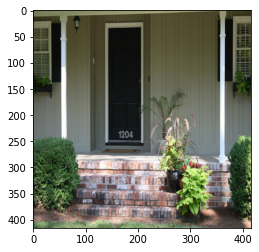

In [ ]:
l = label[2][2]
print(l[l == 1].shape)
plt.imshow(img.permute(1, 2, 0))

In [ ]:
train_batches = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)#, num_workers=2, pin_memory=True)
# test_batches = DataLoader(test_data, batch_size=batch_size, shuffle=False)#, num_workers=2, pin_memory=True)
x, y = next(iter(train_batches))
x.shape, y[2].shape

(torch.Size([16, 3, 416, 416]), torch.Size([16, 3, 52, 52, 6]))

In [ ]:
net = YOLOv3(in_channels=3, num_classes=20).to(device)
inp = torch.randn(1, 3, 416, 416).to(device)
out = net(inp)
print(out[0].shape, out[1].shape, out[2].shape)
del inp, out

torch.Size([1, 3, 13, 13, 25]) torch.Size([1, 3, 26, 26, 25]) torch.Size([1, 3, 52, 52, 25])


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
loss_fn = LossFn()
scaler = torch.cuda.amp.GradScaler()
scaled_anchors = (torch.tensor(anchors) * torch.tensor(scales).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(device)

In [ ]:
def loop(net, batches, device, scaled_anchors, is_train):
    losses = 0
    if is_train:
        print("Train Loop:\n")
        net.train()
    else:
        print("Test Loop:\n")
        net.eval()

    for x, y in tqdm.tqdm(batches, total=len(batches)):
        x = x.to(device)
        y0, y1, y2 = y[0].to(device), y[1].to(device), y[2].to(device)
        if is_train:
            with torch.cuda.amp.autocast():
                preds = net(x)
                loss = loss_fn(preds[0], y0, scaled_anchors[0]) + loss_fn(preds[1], y1, scaled_anchors[1]) + loss_fn(preds[2], y2, scaled_anchors[2])
        else:
            with torch.no_grad():
                preds = net(x)
                loss = loss_fn(preds[0], y0, scaled_anchors[0]) + loss_fn(preds[1], y1, scaled_anchors[1]) + loss_fn(preds[2], y2, scaled_anchors[2])

        losses += loss.item()
        if is_train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    print("\n")
    return losses/len(batches)

In [ ]:
for epoch in range(epochs):
    train_loss = loop(net, train_batches, device, scaled_anchors, True)
    # test_loss = loop(net, test_batches, device, scaled_anchors, False)
    pred_boxes, true_boxes, class_acc, noobj_acc, obj_acc = get_eval_bboxes(net, train_batches, nms_iou_thresh, anchors, conf_thresh, True, device)
    # test_pred_boxes, test_true_boxes, test_class_acc, test_noobj_acc, test_obj_acc = get_eval_bboxes(net, test_batches, nms_iou_thresh, anchors, conf_thresh, False, device)
    train_mAP = mean_average_precision(pred_boxes, true_boxes, map_iou_thresh, num_classes=num_classes)
    # test_mAP = mean_average_precision(test_pred_boxes, test_true_boxes, map_iou_thresh, num_classes=num_classes)
    # print(f"epoch: {epoch} | train_loss: {train_loss} | train_mAP: {train_mAP} | test_loss: {test_loss} | test_mAP: {test_mAP}")
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_mAP: {train_mAP:.4f}\n")
    if epoch % 5 == 0:
        display_images(net, train_batches, conf_thresh, nms_iou_thresh, anchors, class_dict, device)
        print("")

In [ ]:
for _ in range(5):
    display_images(net, train_batches, conf_thresh, nms_iou_thresh, anchors, class_dict, device)
    print("")